# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 14 de mayo de 2024__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__GRUPO: 11__

Alejandro Barrachina Argudo

Jaime Benedí Galdeano

In [317]:
RANDOM_STATE = 1234

# 1) Carga del conjunto de datos

El fichero `spam.csv` contiene mensajes SMS etiquetados como spam or ham (legítimo).

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar. 

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

In [319]:
csv_data = 'spam.csv'
data = pd.read_csv(csv_data, encoding='latin-1')


In [320]:
import string
import numpy as np
def preprocess_data(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

vec_preprocess_data = np.vectorize(preprocess_data)

data['v2'] = vec_preprocess_data(data['v2'])
spam = data[data['v1'] == 'spam']
ham = data[data['v1'] == 'ham']

In [321]:
spam.iloc[0]['v2']

'free entry in  a wkly comp to win fa cup final tkts st may  text fa to  to receive entry questionstd txt ratetcs apply overs'

In [322]:
ham.iloc[0]['v2']

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [323]:
X_train, X_test, y_train, y_test = train_test_split(data['v2'], data['v1'], test_size=0.4, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

<Axes: title={'center': 'Training set'}, ylabel='count'>

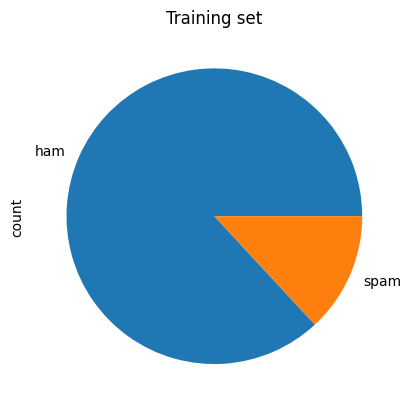

In [324]:
y_train.value_counts().plot(kind='pie', title='Training set')

<Axes: title={'center': 'Test set'}, ylabel='count'>

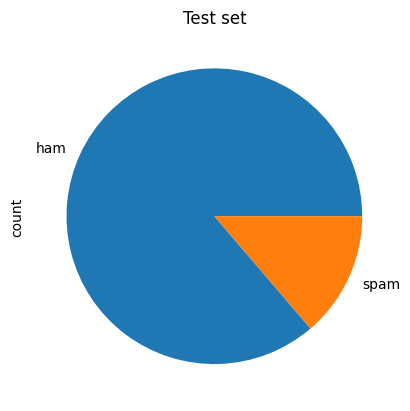

In [325]:
y_test.value_counts().plot(kind='pie', title='Test set')

<Axes: title={'center': 'Validation set'}, ylabel='count'>

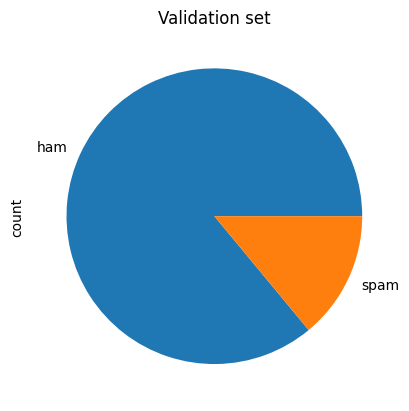

In [326]:
y_val.value_counts().plot(kind='pie', title='Validation set')

In [327]:
# Contamos las palabras que hay en el conjunto de datos
from collections import Counter

count_vectorizer_with_stopwords = Counter()
count_vectorizer_without_stopwords = Counter()
count_vectorizer_with_stopwords.update(' '.join(data['v2']).split())
count_vectorizer_without_stopwords.update(' '.join(data['v2']).split())

In [328]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

for word in stopwords:
    count_vectorizer_without_stopwords.pop(word, None)


[nltk_data] Downloading package stopwords to /home/_alk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [329]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_with_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7501


[('your', 677),
 ('call', 579),
 ('have', 573),
 ('that', 512),
 ('with', 380),
 ('will', 378),
 ('just', 366),
 ('this', 330),
 ('dont', 290),
 ('when', 286),
 ('from', 279),
 ('free', 278),
 ('ltgt', 276),
 ('what', 259),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('then', 233),
 ('come', 226),
 ('only', 215),
 ('time', 208),
 ('there', 196),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('about', 166),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('been', 130),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('some', 125),
 ('cant', 125),
 ('they', 124),
 ('here', 117),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('more', 109),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('wh

In [330]:
count_vectorizer_list = [(c,v) for (c,v) in count_vectorizer_without_stopwords.items() if len(c) > 3] 
print(len(count_vectorizer_list))
count_vectorizer_list.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_list

7436


[('call', 579),
 ('dont', 290),
 ('free', 278),
 ('ltgt', 276),
 ('know', 257),
 ('like', 242),
 ('good', 234),
 ('come', 226),
 ('time', 208),
 ('love', 195),
 ('want', 192),
 ('send', 190),
 ('text', 189),
 ('going', 171),
 ('need', 166),
 ('home', 162),
 ('sorry', 156),
 ('still', 153),
 ('stop', 153),
 ('back', 152),
 ('reply', 144),
 ('today', 141),
 ('mobile', 139),
 ('tell', 137),
 ('well', 134),
 ('later', 134),
 ('think', 132),
 ('please', 130),
 ('take', 126),
 ('phone', 126),
 ('cant', 125),
 ('week', 116),
 ('claim', 113),
 ('much', 113),
 ('night', 113),
 ('dear', 113),
 ('great', 111),
 ('happy', 106),
 ('hope', 103),
 ('make', 101),
 ('thats', 101),
 ('give', 100),
 ('work', 99),
 ('number', 94),
 ('prize', 92),
 ('right', 92),
 ('already', 90),
 ('tomorrow', 90),
 ('really', 86),
 ('yeah', 86),
 ('said', 86),
 ('message', 83),
 ('didnt', 83),
 ('meet', 78),
 ('babe', 78),
 ('last', 78),
 ('morning', 77),
 ('life', 77),
 ('miss', 76),
 ('thanks', 76),
 ('would', 76),
 ('

In [331]:
count_vectorizer_train_spam = Counter()
count_vectorizer_train_ham = Counter()
count_vectorizer_train_spam.update(' '.join(X_train[y_train == 'spam']).split())
count_vectorizer_train_ham.update(' '.join(X_train[y_train == 'ham']).split())

In [332]:
for words in stopwords:
    count_vectorizer_train_spam.pop(words, None)
    count_vectorizer_train_ham.pop(words, None)

In [333]:
count_vectorizer_train_spam = [(c,v)for (c,v) in count_vectorizer_train_spam.items() if len(c) > 3]
count_vectorizer_train_spam.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_spam

[('call', 213),
 ('free', 126),
 ('mobile', 79),
 ('text', 73),
 ('stop', 71),
 ('reply', 67),
 ('claim', 63),
 ('prize', 51),
 ('send', 42),
 ('service', 42),
 ('contact', 41),
 ('nokia', 40),
 ('cash', 39),
 ('urgent', 38),
 ('guaranteed', 32),
 ('phone', 31),
 ('please', 31),
 ('customer', 29),
 ('chat', 28),
 ('awarded', 25),
 ('line', 25),
 ('mins', 25),
 ('landline', 25),
 ('week', 25),
 ('camera', 23),
 ('tone', 23),
 ('live', 22),
 ('video', 21),
 ('message', 21),
 ('draw', 20),
 ('shows', 20),
 ('holiday', 20),
 ('number', 20),
 ('latest', 19),
 ('want', 18),
 ('receive', 18),
 ('offer', 17),
 ('award', 17),
 ('network', 17),
 ('attempt', 16),
 ('collection', 16),
 ('code', 16),
 ('ringtone', 16),
 ('every', 16),
 ('delivery', 15),
 ('bonus', 15),
 ('chance', 14),
 ('tones', 14),
 ('orange', 14),
 ('club', 14),
 ('back', 14),
 ('dating', 14),
 ('cost', 14),
 ('gift', 13),
 ('weekly', 13),
 ('find', 13),
 ('time', 13),
 ('apply', 13),
 ('land', 13),
 ('tried', 13),
 ('valid', 1

In [334]:
count_vectorizer_train_ham = [(c,v)for (c,v) in count_vectorizer_train_ham.items() if len(c) > 3]
count_vectorizer_train_ham.sort(key=lambda x: x[1], reverse=True)
count_vectorizer_train_ham

[('ltgt', 179),
 ('dont', 157),
 ('know', 148),
 ('call', 146),
 ('like', 135),
 ('come', 134),
 ('good', 125),
 ('time', 110),
 ('love', 109),
 ('going', 108),
 ('home', 98),
 ('want', 97),
 ('sorry', 96),
 ('need', 91),
 ('tell', 86),
 ('send', 85),
 ('later', 85),
 ('still', 83),
 ('well', 77),
 ('think', 76),
 ('back', 75),
 ('take', 74),
 ('today', 70),
 ('much', 67),
 ('yeah', 64),
 ('thats', 64),
 ('cant', 64),
 ('great', 61),
 ('night', 60),
 ('hope', 55),
 ('give', 54),
 ('already', 53),
 ('said', 53),
 ('work', 52),
 ('dear', 51),
 ('make', 50),
 ('happy', 49),
 ('please', 49),
 ('didnt', 48),
 ('right', 48),
 ('morning', 47),
 ('text', 46),
 ('phone', 46),
 ('life', 46),
 ('sure', 45),
 ('meet', 44),
 ('miss', 44),
 ('really', 43),
 ('something', 43),
 ('also', 42),
 ('would', 42),
 ('last', 42),
 ('friends', 42),
 ('soon', 41),
 ('went', 41),
 ('around', 41),
 ('free', 41),
 ('tomorrow', 40),
 ('pick', 40),
 ('wait', 40),
 ('number', 40),
 ('sent', 39),
 ('many', 38),
 ('ni

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

In [335]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(X_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [337]:
vocab = cv.get_feature_names_out()

pd.DataFrame(cv_matrix, columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [339]:
X_train.iloc[27]

'mmm so yummy babe  nice jolt to the suzy'

In [340]:
cv_matrix[27]

array([0, 0, 0, ..., 0, 0, 0])

In [341]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(X_train)
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,aa,aaniye,aathilove,aathiwhere,ab,abdomen,abeg,aberdeen,abi,ability,...,zac,zealand,zed,zf,zindgi,zoe,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [342]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix) 
similarity_df


,0,1,2,3,4,5,6,7,8,9,...,3333,3334,3335,3336,3337,3338,3339,3340,3341,3342
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.053020,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,1.000000,0.009400,0.019624,0.000000,0.034574,0.0,0.013945,0.009275,0.000000,...,0.115387,0.000000,0.009643,0.016956,0.000000,0.0,0.000000,0.0,0.000000,0.033011
2,0.0,0.009400,1.000000,0.043820,0.077169,0.000000,0.0,0.009352,0.006220,0.028558,...,0.038085,0.000000,0.078682,0.042632,0.000000,0.0,0.078845,0.0,0.000000,0.042283
3,0.0,0.019624,0.043820,1.000000,0.000000,0.000000,0.0,0.019525,0.012986,0.040341,...,0.170140,0.044553,0.040543,0.023741,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.077169,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.076757,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.026316,0.000000,...,0.045062,0.000000,0.030592,0.000000,0.083812,1.0,0.000000,0.0,0.000000,0.000000
3339,0.0,0.000000,0.078845,0.000000,0.076757,0.000000,0.0,0.000000,0.000000,0.000000,...,0.026225,0.000000,0.000000,0.052897,0.000000,0.0,1.000000,0.0,0.047066,0.000000
3340,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000
3341,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.021160,0.000000,0.000000,0.042681,0.000000,0.0,0.047066,0.0,1.000000,0.000000


# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.